In [1]:
import json, glob, os, sys
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sys.path.append(CODE) # set sys.path in order to load modules
from calc_util import sliding_maxnorm_ht
from adaint import integrate, default_steps_per_time, integrate2
import system #,container, setup
from scipy.integrate import odeint

In [2]:
def f(X, t, S, k1, k2, k3, kMa, kIa2, kIi2, kRa2, kRi2, kMa2, kMi2):
    # starting values
    R, Ri, I2, M2, R2, Ra = X

    dR  = k3*(1-Ra-R) - k1*S*(1-Ri-Ra)
    dRi = k2*(1-R-Ri) - k3*(1-R-Ra) + kMa*M2*Ra
    dI2 = kIa2*Ra*(1-I2) - kIi2*I2
    dM2 = kMa2*R2*(1-M2) - kMi2*M2
    dR2 = kRa2*I2*(1-R2) - kRi2*R2
    dRa = S*k1*(1-Ra-Ri) - k2*(1-Ri-R) - kMa*M2*Ra

    return(dR, dRi, dI2, dM2, dR2, dRa)

In [3]:
# set parameters


p0=[ 0.123610, 0.772732, 0.104607, 0.903910, 1.033100, 5.04596, 1.002160, 5.75706, 2.51961, 0.000594] #only rates and ODE parameters
Ton=1.0
Amin=0

X0 = [1,0,0,0,0,0] #Rr, Ri, I2, M2, R2, Ra. Assume all receptor starts at Rr, which is what corresponds to the ss if Amin=0
labels=[r"$R_r$", r"$R_i$", r"$I_2$", r"$M_2$", r"$R_2$", r"$R_a$"] #should match order in X0

mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

for ht threshold 0.01, and T=5, habituation time is ht=7 stimuli, and recovery=1271.8 t.u.
for ht threshold 0.01, and T=10, habituation time is ht=9 stimuli, and recovery=1911.27 t.u.
for ht threshold 0.01, and T=15, habituation time is ht=10 stimuli, and recovery=2153.28 t.u.


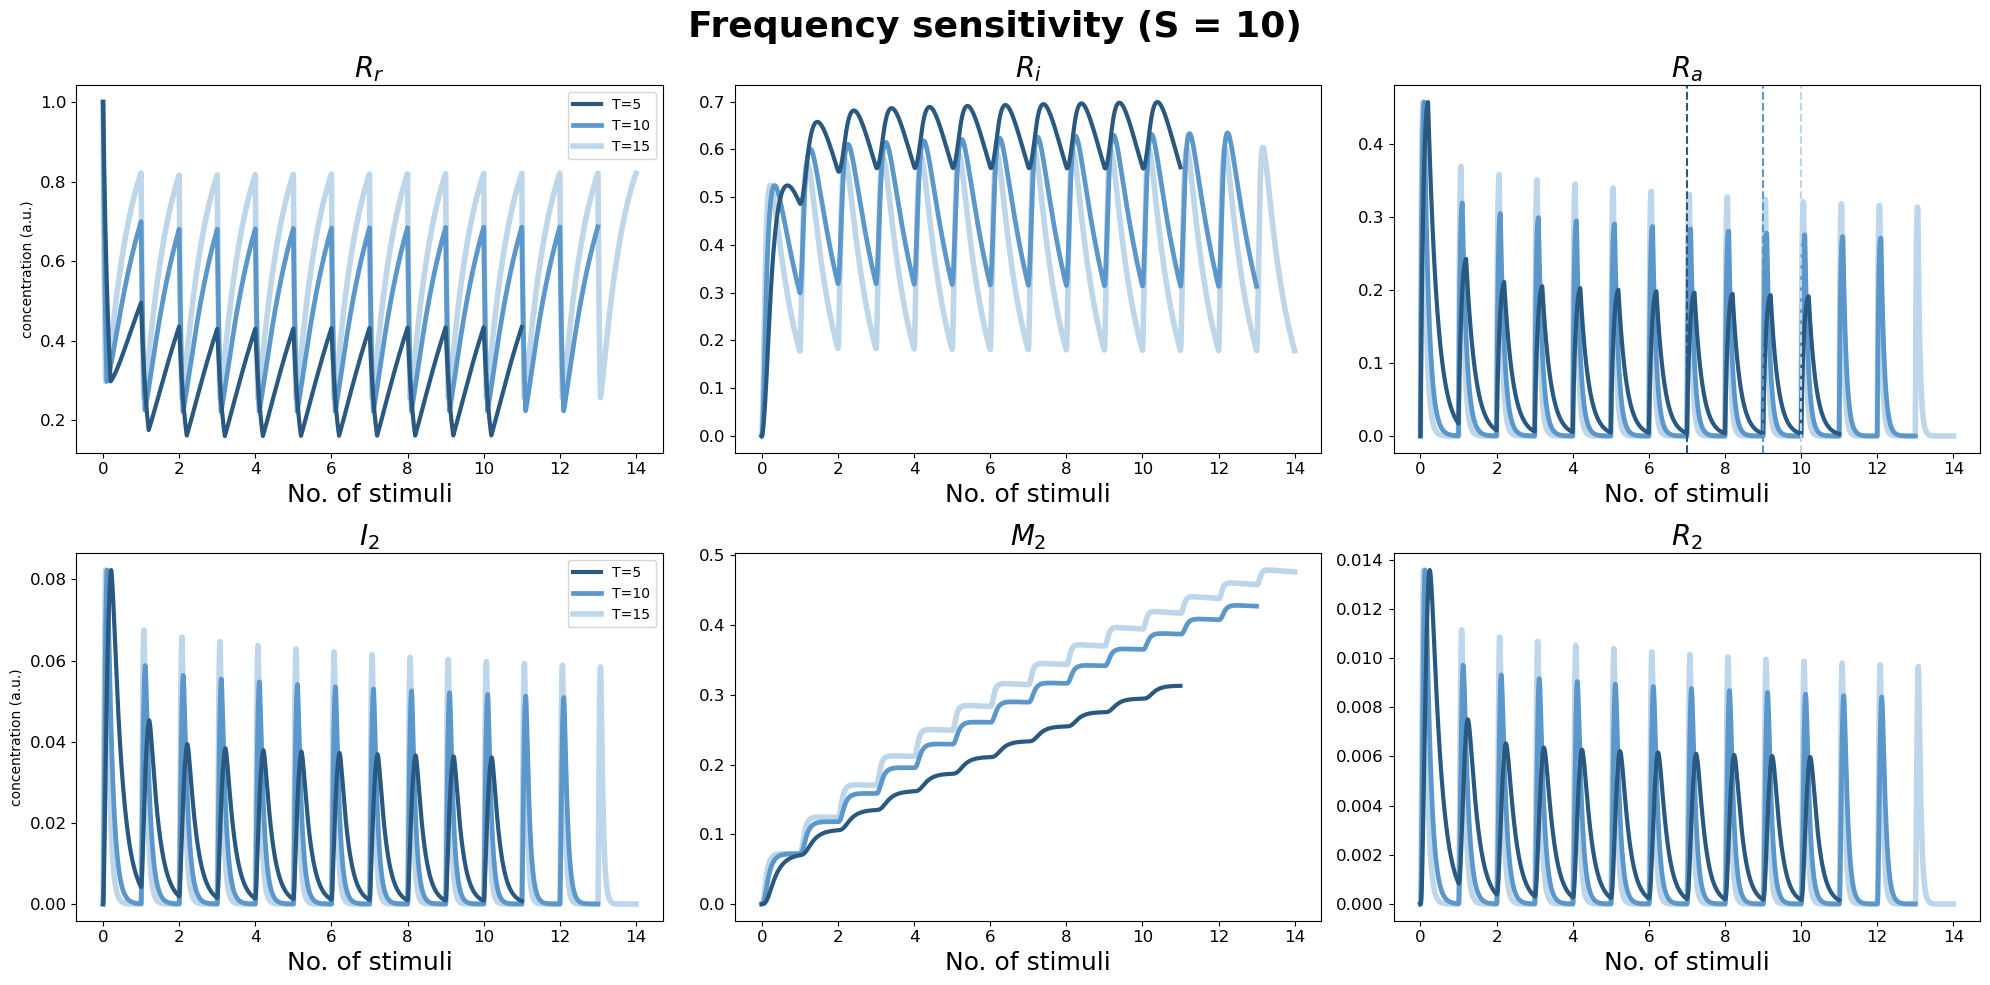

for ht threshold 0.008, and T=5, habituation time is ht=11 stimuli, and recovery=1765.24 t.u.
for ht threshold 0.008, and T=10, habituation time is ht=12 stimuli, and recovery=2209.57 t.u.
for ht threshold 0.008, and T=15, habituation time is ht=12 stimuli, and recovery=2331.05 t.u.


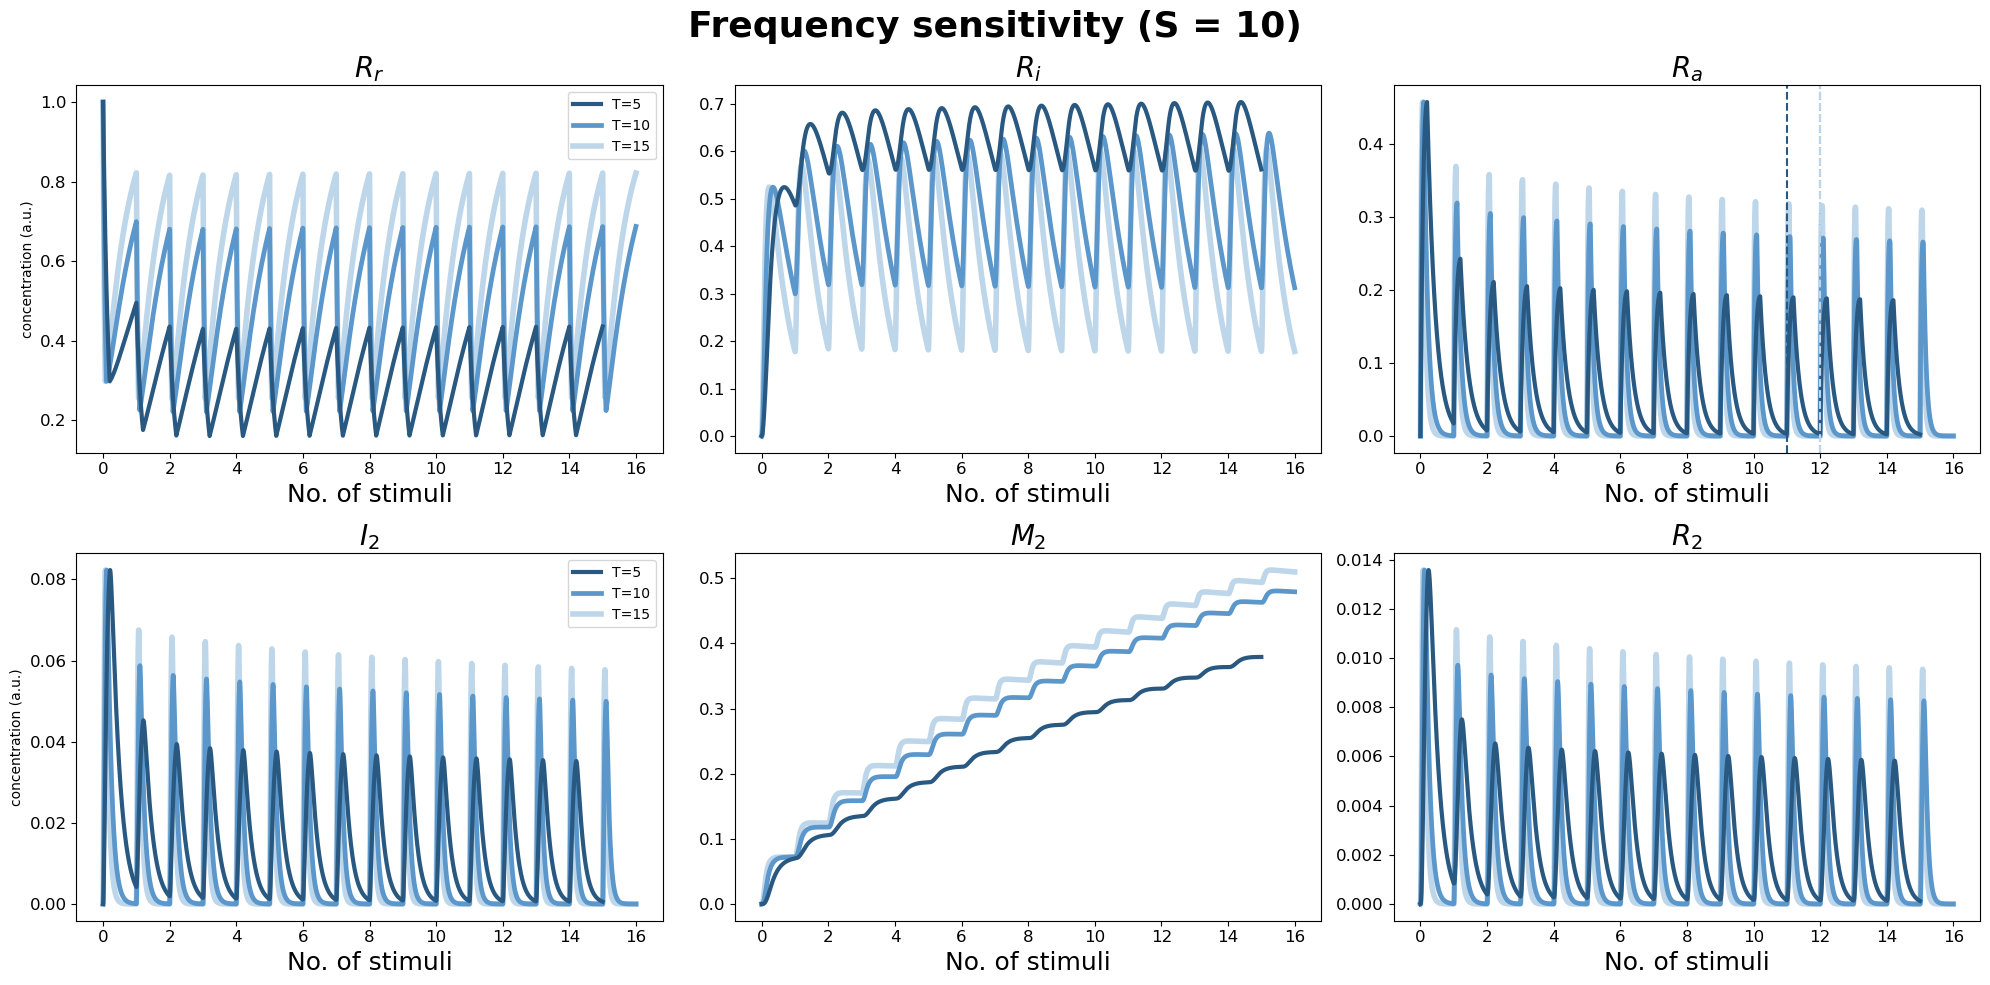

In [5]:
S=10
T_scan_set = [5, 10, 15]
#for ht_threshold in [0.01,0.007]:
for ht_threshold in [0.01,0.008]:
    traj = []
    tvecs = []
    ht = []
    rt=[]
    for j, T in enumerate(T_scan_set): 
        ht_,rt_=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
        ht.append(ht_)
        rt.append(rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        
        print("for ht threshold %g, and T=%d, habituation time is ht=%d stimuli, and recovery=%g t.u."%(ht_threshold,T,ht_,rt_))
        
    
    plot=True
    if plot:
        # overlay plot for frequency sensitivity
        colors = ['#295981', '#5b97ca', '#bed6ea']
        lw = [2*1.5,2*1.7,2*2]
        al = [1.0,1.0,1.0]

        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

        for j,T in enumerate(T_scan_set):
            y = traj[j]
            tvec = tvecs[j]/T #plot with respect to stimulus number rather than time
            for k in range(0,6):
                #order of variables is #Rr, Ri, I2, M2, R2, Ra . We want to plot Rr, Ri, Ra // I2, M2, R2
                if k==0:
                    ax=axes[0][0]
                elif k==1:
                    ax=axes[0][1]
                elif k==2:
                    ax=axes[1][0] 
                elif k==3:
                    ax=axes[1][1]
                elif k==4:
                    ax=axes[1][2]
                elif k==5:
                    ax=axes[0][2]
                    ax.axvline(x=ht[j],linestyle="--",color=colors[j])
                ax.set_title(labels[k], fontsize=20)
                ax.plot(tvec, y[:,k], color=colors[j], lw=lw[j], alpha=al[j],label="T=%d"%T,zorder=(2-j))


                ax.set_xlabel('No. of stimuli', fontsize=18)
                ax.xaxis.set_tick_params(labelsize=12)
                ax.yaxis.set_tick_params(labelsize=12)

                if ax==axes[0][0] or ax==axes[1][0]:
                    ax.set_ylabel('concentration (a.u.)')
                    ax.legend()
        #sns.despine()
        fig.suptitle('Frequency sensitivity (S = %d)'%S,  fontweight="bold", fontsize=26)
        plt.tight_layout()
        plt.show()

# Recovery envelope

In [5]:
from scipy.signal import find_peaks
T_scan_set = [5, 10, 15]
S=10
idxm=4 #index of the memory species
ht_threshold=0.01
peak_norm_Ts = []
tperturblist_Ts = []

for T in T_scan_set:
    ht, rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
    #tperturblist=np.linspace(5,rt,40) #times after habituation at which perturbation is applied, starting always from habituation time
    tperturblist = np.logspace(np.log10(T), np.log10(rt), 25, endpoint=True)
    tperturblist_Ts.append(tperturblist)
    tvec=mys.computational_data["tvec"]
    htstep=mys.computational_data["habituation_time_step"]
    trajectory=mys.computational_data["trajectory"][:htstep,:]
    habituation_time=mys.computational_data["habituation_time"]
    times_envelope = []
    peaks_envelope = []
    for t in tperturblist:
        tvecr,recovery_trajectory=mys.integrate_posthabituation_atAmin(tend=t)
        perturbational_tvec, perturbational_trajectory = mys.apply_singlestimulus(recovery_trajectory[-1])
        output_var = perturbational_trajectory[:,mys.output_variable]
        peak, _ = find_peaks(output_var) #, height=0
        lista = output_var[peak]
        lista_times = perturbational_tvec[peak]
        peaks_envelope.append(lista[-1])
        
        all_tvec=tvec[:htstep].copy()
        all_tvec=np.concatenate((all_tvec,tvecr))
        times_envelope.append(lista_times[-1]+all_tvec[-1])
    peak_norm = np.array(peaks_envelope)/mys.computational_data['peaks_level'][0]
    peak_norm_Ts.append(peak_norm)

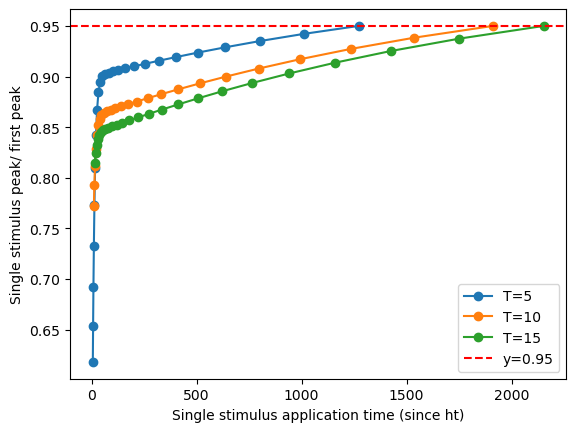

In [6]:
for j,T in enumerate(T_scan_set):
    plt.plot(tperturblist_Ts[j], peak_norm_Ts[j], "o-", label="T=%d"%T)
plt.axhline(y=0.95, color="r", alpha=1.0, ls="--", label = "y=0.95")
plt.xlabel("Single stimulus application time (since ht)")
plt.ylabel("Single stimulus peak/ first peak")
plt.legend()
plt.show()

# Intensity sensitivity

for ht threshold 0.006, and S=3, habituation time is ht=12 stimuli, and recovery=1242.23 t.u.
for ht threshold 0.006, and S=5, habituation time is ht=16 stimuli, and recovery=2010.54 t.u.
for ht threshold 0.006, and S=10, habituation time is ht=16 stimuli, and recovery=2481.27 t.u.


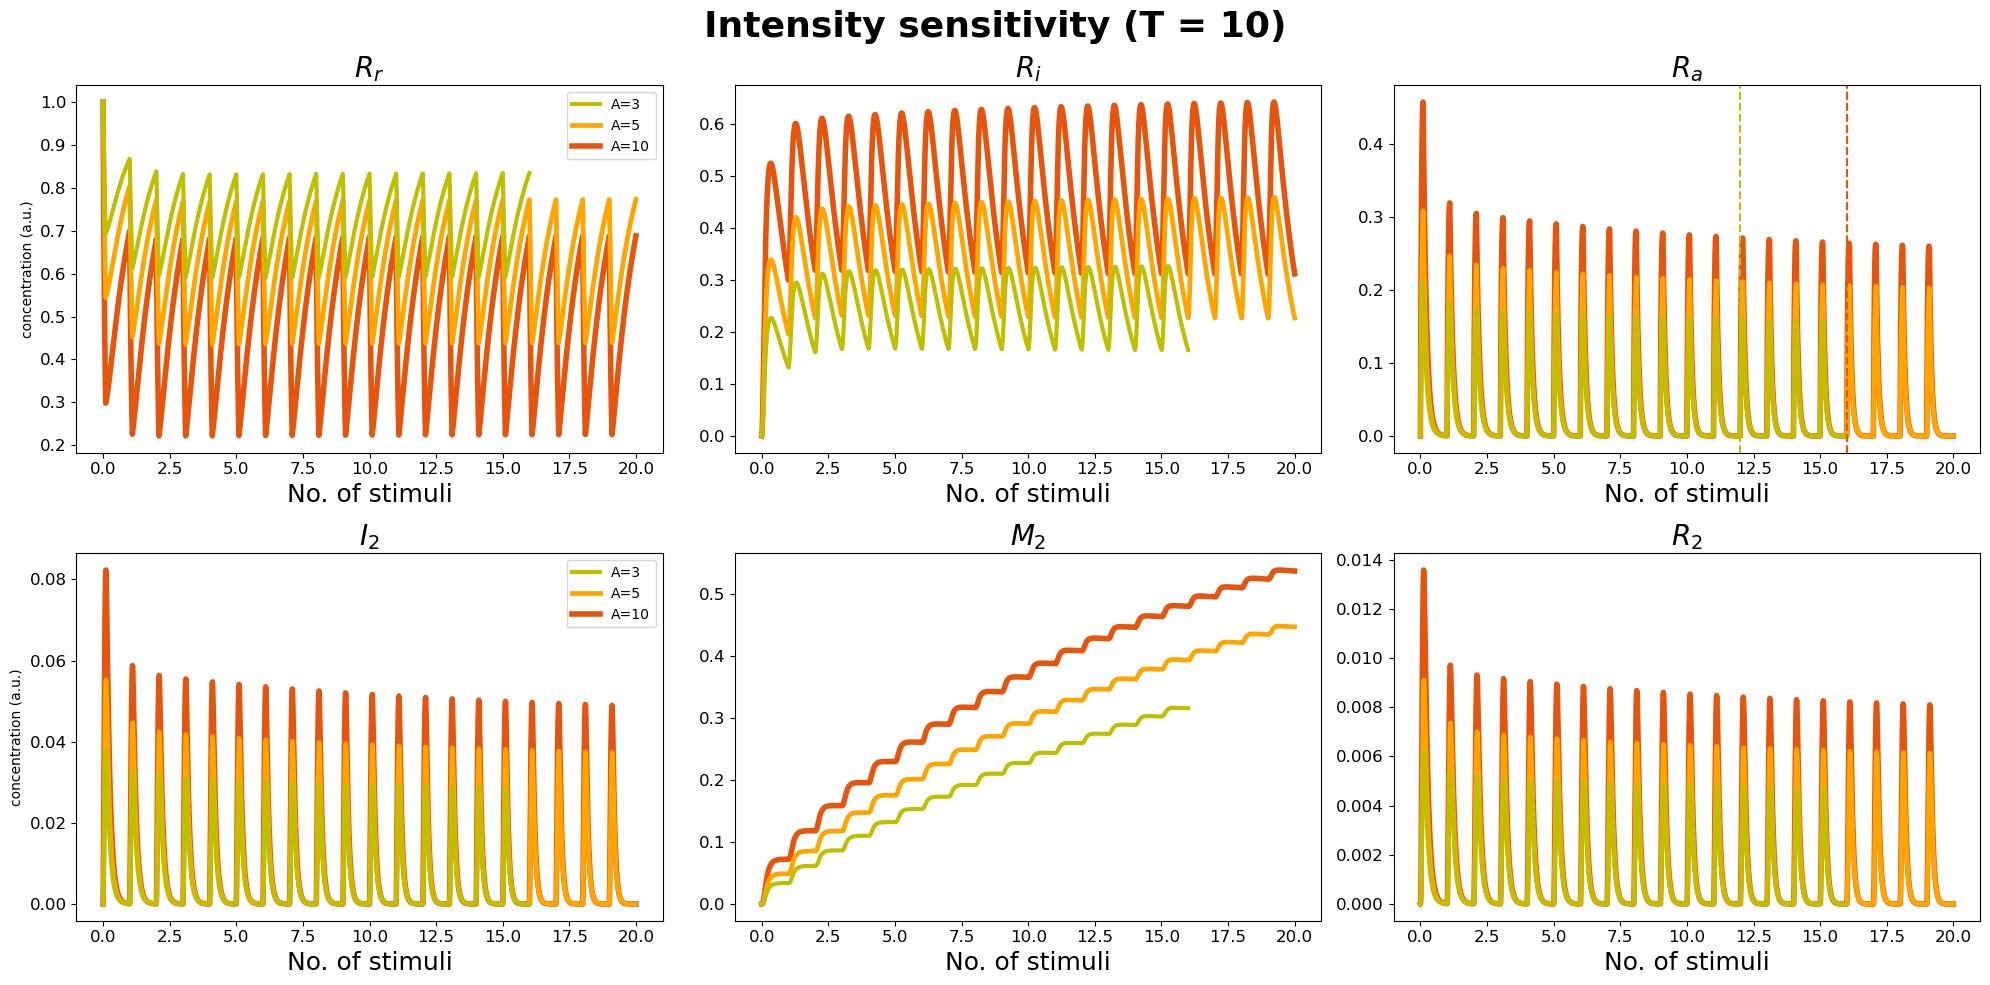

for ht threshold 0.005, and S=3, habituation time is ht=17 stimuli, and recovery=1641.1 t.u.
for ht threshold 0.005, and S=5, habituation time is ht=20 stimuli, and recovery=2225.79 t.u.
for ht threshold 0.005, and S=10, habituation time is ht=19 stimuli, and recovery=2629.08 t.u.


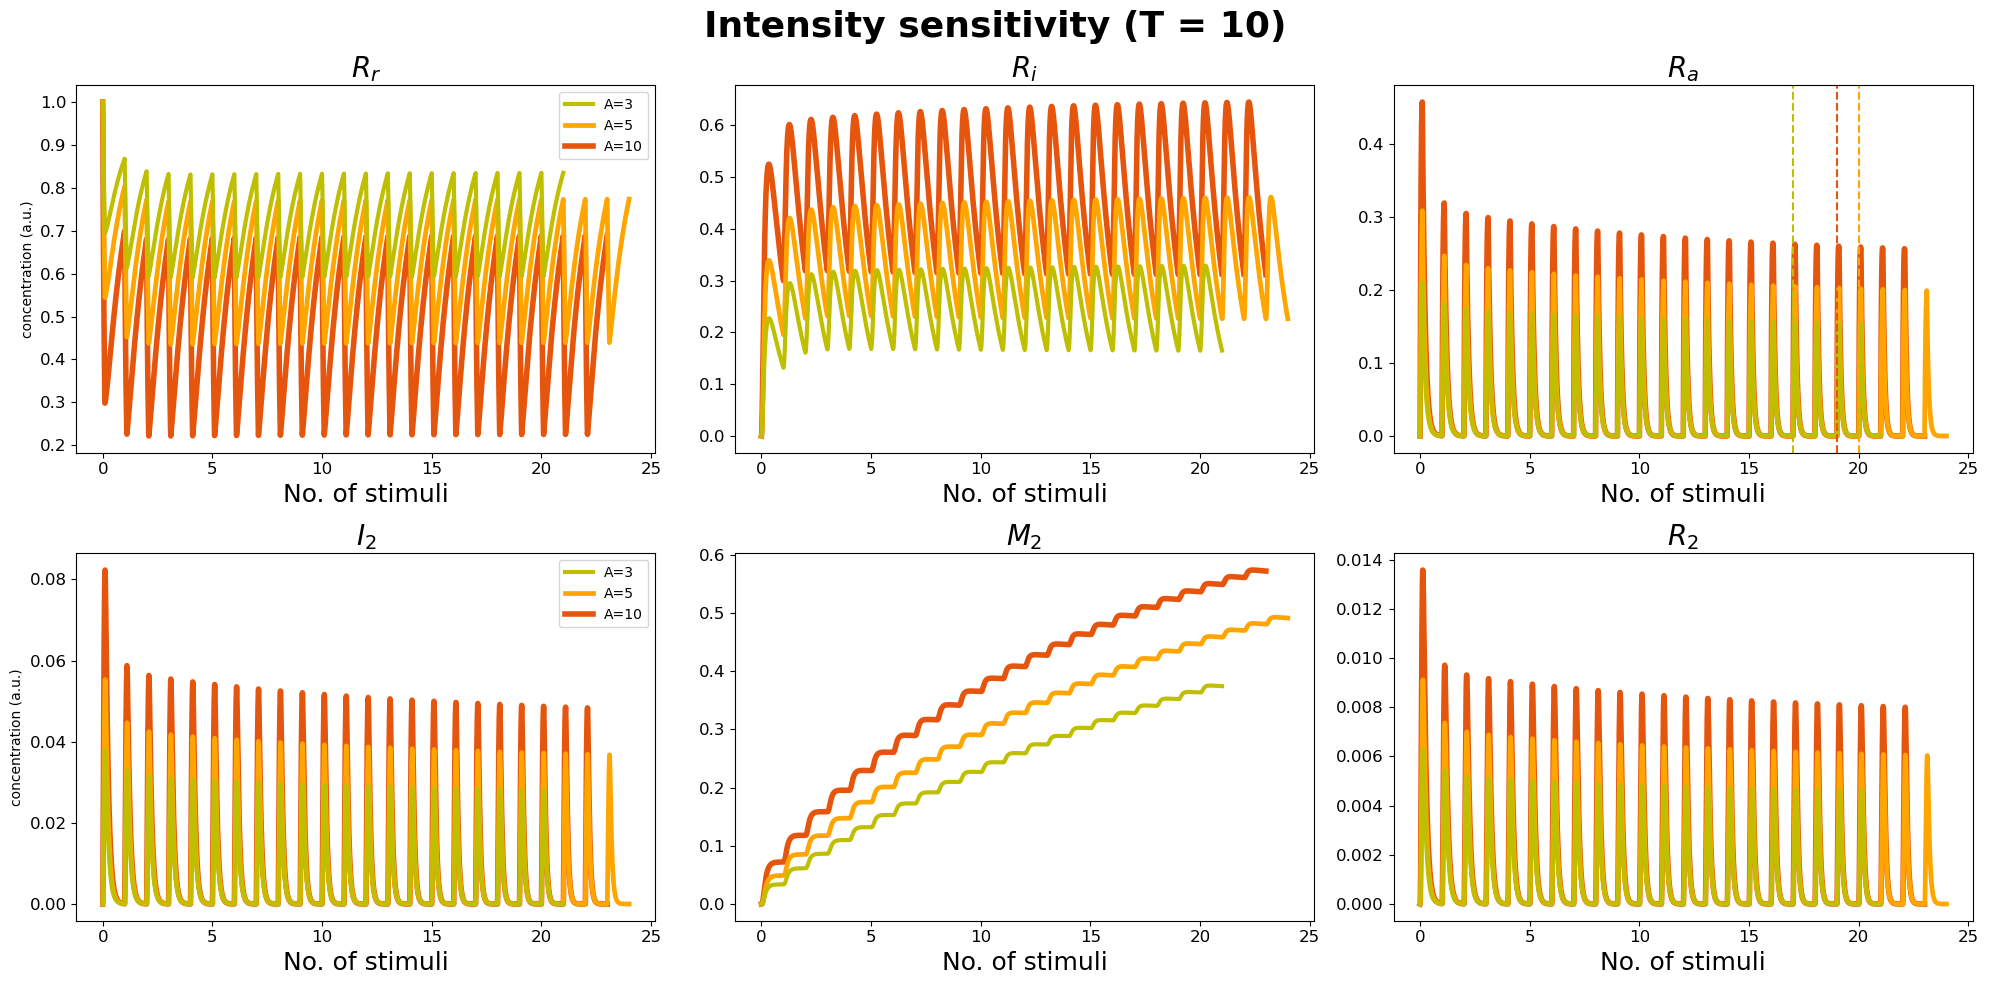

In [7]:
lw = [2*1.5,2*1.7,2*2]
al = [1.0,1.0,1.0]
colors = ["y",  "orange",plt.cm.tab20c(4)]

T=10
Amplitudes = [3, 5, 10]
for ht_threshold in [0.006,0.005]:
    traj = []
    tvecs = []
    ht = []
    rt=[]
    for j, Amax in enumerate(Amplitudes): 
        ht_,rt_=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold,recovery_threshold=0.95)
        ht.append(ht_)
        rt.append(rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        
        print("for ht threshold %g, and S=%d, habituation time is ht=%d stimuli, and recovery=%g t.u."%(ht_threshold,Amax,ht_,rt_))
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    for j, Amax in enumerate(Amplitudes):
        y = traj[j]
        tvec = tvecs[j]/T
        for k in range(0,6):
            #order of variables is #Rr, Ri, I2, M2, R2, Ra . We want to plot Rr, Ri, Ra // I2, M2, R2
            if k==0:
                ax=axes[0][0]
            elif k==1:
                ax=axes[0][1]
            elif k==2:
                ax=axes[1][0] 
            elif k==3:
                ax=axes[1][1]
            elif k==4:
                ax=axes[1][2]
            elif k==5:
                ax=axes[0][2]
                ax.axvline(x=ht[j],linestyle="--",color=colors[j])
            ax.set_title(labels[k], fontsize=20)
            ax.plot(tvec, y[:,k], color=colors[j], lw=lw[j], alpha=al[j],label="A=%d"%Amax,zorder=(2-j))

            ax.set_xlabel('No. of stimuli', fontsize=18)
            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)

            if ax==axes[0][0] or ax==axes[1][0]:
                ax.set_ylabel('concentration (a.u.)')
                ax.legend()
    #sns.despine()
    fig.suptitle('Intensity sensitivity (T = ' +str(T) +")",  fontweight="bold", fontsize=26)
    plt.tight_layout()
    plt.show()

# Potentiation of habituation 

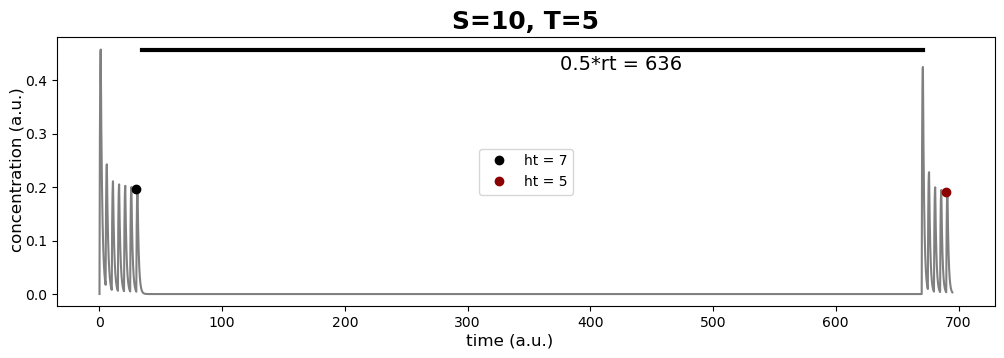

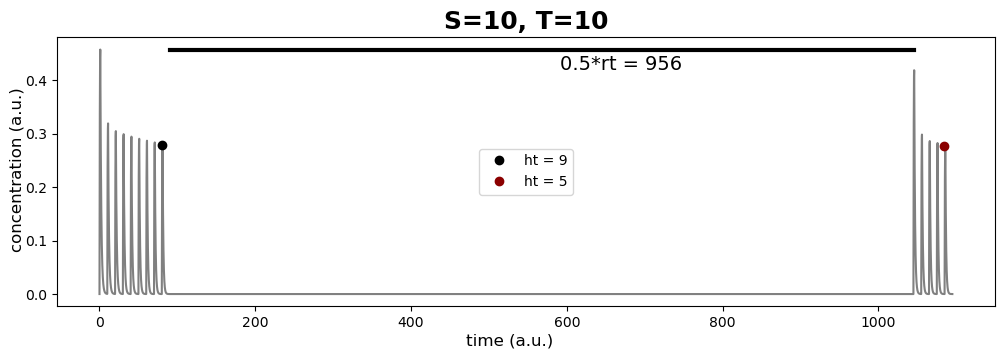

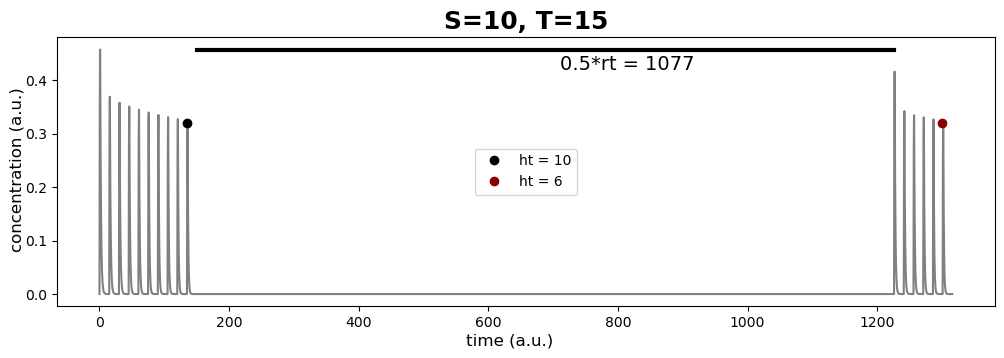

In [9]:
S=10
T_scan_set = [5, 10, 15]
ht_threshold=0.01
for T in T_scan_set:
    X0 = [1,0,0,0,0,0] #initial steady-state
    mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)
    ht,rt=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)

    rt_fraction = 0.5
    steps_per_time=mys.steps_per_time

    # extract new initial conditions at p*rt from recovery trajectory with p in (0,1)
    data = mys.computational_data
    peaks_level=data["peaks_level"]
    recovery_trajectory = data['recovery_trajectory']
    X1 = recovery_trajectory[int(rt_fraction*int(rt))*steps_per_time]
    X1[X1 < 0] = 0 # prevent negative blowup
    
    mys=system.System(f,p0, X1,output_var_idx=-1,steps_per_time=100,hmax=0) #new habituation train starting from X1
    ht2,rt2=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=ht_threshold,recovery_threshold=0.95)
    data2=mys.computational_data

    ### plot
    # concatenate all trajectories 
    #(1st stimulation until habituated, recovery fraction, 2nd stimulation until habituated)
    htstp1=data["habituation_time_step"]
    traj1=data["trajectory"]
    htstp2=data2["habituation_time_step"]
    traj2=data2["trajectory"]
    x = np.concatenate([traj1[:htstp1,mys.output_variable], recovery_trajectory[:,mys.output_variable][:int(rt_fraction*int(rt))*mys.steps_per_time], traj2[:htstp2,-1] ])
    ht_peak_level = data['peaks_level'][ht]
    ht_time = data["habituation_time"]
    ht_new_peak_level = data2["peaks_level"][ht2]
    ht_new_time = ht_time + rt_fraction*rt + ht2*T-1

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 3.5))
    ax.plot(np.arange(0,len(x))/steps_per_time, x,color='grey')
    ax.plot(ht_time-(mys.T),ht_peak_level, 'o', color='black', label='ht = '+str(ht))
    ax.plot(ht_new_time-(mys.T), ht_new_peak_level, 'o', color='darkred', label='ht = '+str(ht2))

    ax.plot([(ht)*T,ht_time + rt_fraction*rt], [peaks_level[0], peaks_level[0]], color='black', lw=3)

    fig.text(0.55, 0.8, str(rt_fraction) + '*rt = ' + str(round(rt_fraction*rt)), va='center', fontsize=14) 

    fig.text(0.5,0, 'time (a.u.)', ha='center', fontsize=12)
    fig.text(0, 0.5, 'concentration (a.u.)', va='center', rotation='vertical', fontsize=12)
    plt.title("S=" + str(S) + ", T=" + str(T),  fontweight="bold", fontsize=18)
    plt.legend()
    #sns.despine()
    plt.tight_layout()
    #plt.savefig(DATA+'22_06_22_7/figures/thesis_0/potentiation_08.pdf')
    plt.show()

# Subliminal accumulation

In [10]:
### integrate system, compute rt
# integrate with low ht threshold
T=5
S=10
X0 = [1,0,0,0,0,0] #initial steady-state
mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

ht_high_threshold,rt_high_threshold=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01,recovery_threshold=0.95)
data_high=mys.computational_data
htstp1=data_high["habituation_time_step"]

ht_low_threshold,rt_low_threshold=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.005,recovery_threshold=0.95)
data_low=mys.computational_data
htstp2=data_low["habituation_time_step"]

recovery_trajectory_high_threshold = data_high['recovery_trajectory']
differences=[]
ppeaks=[]
rt_target=rt_high_threshold-mys.step_size
for key in data_high['perturbational_trajectory'].keys():
    differences.append(np.abs(key-rt_target))
    ppeaks.append(data_high["perturbational_trajectory"][key])
recovery_peak_high_threshold = ppeaks[np.argmin(differences)] #avoid rounding issues

recovery_trajectory_low_threshold = data_low['recovery_trajectory']
rt_target=rt_low_threshold-mys.step_size
differences=[]
ppeaks=[]
for key in data_low['perturbational_trajectory'].keys():
    differences.append(np.abs(key-rt_target))
    ppeaks.append(data_low["perturbational_trajectory"][key])
    
recovery_peak_low_threshold = ppeaks[np.argmin(differences)] #avoid rounding issues

print(ht_high_threshold, ht_low_threshold, rt_high_threshold, rt_low_threshold)

7 20 1271.8 2368.17


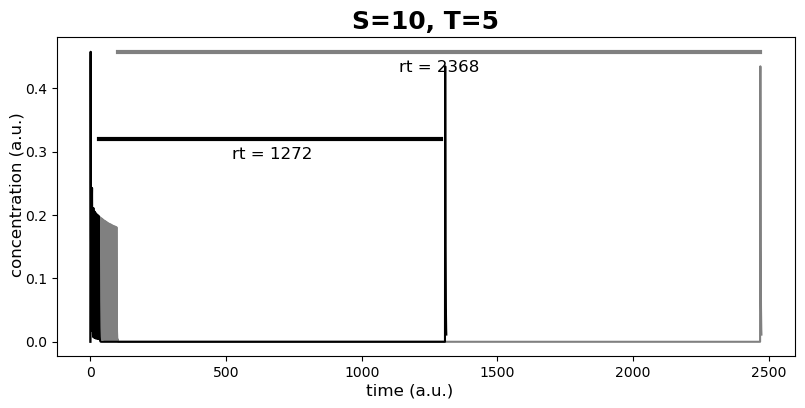

In [11]:
### plot
# concatenate data for plot
x_high_threshold = np.concatenate([data_high["trajectory"][:,mys.output_variable][:htstp1], 
                     recovery_trajectory_high_threshold[:int(rt_high_threshold*mys.steps_per_time),mys.output_variable],
                     recovery_peak_high_threshold[:,mys.output_variable]])
x_low_threshold = np.concatenate([data_low["trajectory"][:,mys.output_variable][:htstp2], 
                     recovery_trajectory_high_threshold[:int(rt_low_threshold*mys.steps_per_time),mys.output_variable],
                     recovery_peak_low_threshold[:,mys.output_variable]])
t_high_threshold = np.arange(0,len(x_high_threshold))/mys.steps_per_time
t_low_threshold = np.arange(0,len(x_low_threshold))/mys.steps_per_time
max_peak = max(data["peaks_level"])


fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 4))
ax = axes
ax.plot(t_low_threshold, x_low_threshold, color='grey')
ax.plot([ht_low_threshold*T, ht_low_threshold*T+rt_low_threshold], [max_peak, max_peak], 
        color='grey', lw=3)
ax.text(ht_low_threshold*T+0.5*rt_low_threshold, 0.93*max_peak, 
        'rt = '+str(round(rt_low_threshold)), ha='center', fontsize=12)

ax.plot(t_high_threshold, x_high_threshold, color='black')
ax.plot([ht_high_threshold*T-5, ht_high_threshold*T+rt_high_threshold-15], [0.7*max_peak, 0.7*max_peak], 
        color='black', lw=3) # -5 arbiträr!!!
ax.text(ht_high_threshold*T+0.5*rt_high_threshold, 0.63*max_peak, 
        'rt = '+str(round(rt_high_threshold)), ha='center', fontsize=12)

fig.text(0.5, -0, 'time (a.u.)', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'concentration (a.u.)', va='center', rotation='vertical', fontsize=12)
plt.title("S=" + str(S) + ", T=" + str(T),  fontweight="bold", fontsize=18)
#sns.despine()
plt.tight_layout()
#plt.savefig(DATA+'22_06_22_7/figures/thesis_0/subliminal_overlay.pdf')
plt.show()

In [12]:
### integrate system, compute rt
# integrate with low ht threshold
T=10
S=10
X0 = [1,0,0,0,0,0] #initial steady-state
mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

ht_high_threshold,rt_high_threshold=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01,recovery_threshold=0.95)
data_high=mys.computational_data
htstp1=data_high["habituation_time_step"]

ht_low_threshold,rt_low_threshold=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.005,recovery_threshold=0.95)
data_low=mys.computational_data
htstp2=data_low["habituation_time_step"]

recovery_trajectory_high_threshold = data_high['recovery_trajectory']
differences=[]
ppeaks=[]
rt_target=rt_high_threshold-mys.step_size
for key in data_high['perturbational_trajectory'].keys():
    differences.append(np.abs(key-rt_target))
    ppeaks.append(data_high["perturbational_trajectory"][key])
recovery_peak_high_threshold = ppeaks[np.argmin(differences)] #avoid rounding issues

recovery_trajectory_low_threshold = data_low['recovery_trajectory']
rt_target=rt_low_threshold-mys.step_size
differences=[]
ppeaks=[]
for key in data_low['perturbational_trajectory'].keys():
    differences.append(np.abs(key-rt_target))
    ppeaks.append(data_low["perturbational_trajectory"][key])
    
recovery_peak_low_threshold = ppeaks[np.argmin(differences)] #avoid rounding issues

print(ht_high_threshold, ht_low_threshold, rt_high_threshold, rt_low_threshold)

9 19 1911.27 2629.08


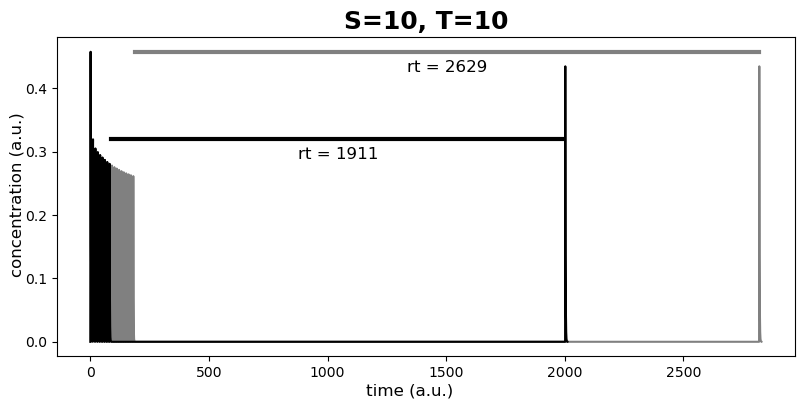

In [13]:
### plot
# concatenate data for plot
x_high_threshold = np.concatenate([data_high["trajectory"][:,mys.output_variable][:htstp1], 
                     recovery_trajectory_high_threshold[:int(rt_high_threshold*mys.steps_per_time),mys.output_variable],
                     recovery_peak_high_threshold[:,mys.output_variable]])
x_low_threshold = np.concatenate([data_low["trajectory"][:,mys.output_variable][:htstp2], 
                     recovery_trajectory_high_threshold[:int(rt_low_threshold*mys.steps_per_time),mys.output_variable],
                     recovery_peak_low_threshold[:,mys.output_variable]])
t_high_threshold = np.arange(0,len(x_high_threshold))/mys.steps_per_time
t_low_threshold = np.arange(0,len(x_low_threshold))/mys.steps_per_time
max_peak = max(data["peaks_level"])


fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 4))
ax = axes
ax.plot(t_low_threshold, x_low_threshold, color='grey')
ax.plot([ht_low_threshold*T, ht_low_threshold*T+rt_low_threshold], [max_peak, max_peak], 
        color='grey', lw=3)
ax.text(ht_low_threshold*T+0.5*rt_low_threshold, 0.93*max_peak, 
        'rt = '+str(round(rt_low_threshold)), ha='center', fontsize=12)

ax.plot(t_high_threshold, x_high_threshold, color='black')
ax.plot([ht_high_threshold*T-5, ht_high_threshold*T+rt_high_threshold-15], [0.7*max_peak, 0.7*max_peak], 
        color='black', lw=3) # -5 arbiträr!!!
ax.text(ht_high_threshold*T+0.5*rt_high_threshold, 0.63*max_peak, 
        'rt = '+str(round(rt_high_threshold)), ha='center', fontsize=12)

fig.text(0.5, -0, 'time (a.u.)', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'concentration (a.u.)', va='center', rotation='vertical', fontsize=12)
plt.title("S=" + str(S) + ", T=" + str(T),  fontweight="bold", fontsize=18)
#sns.despine()
plt.tight_layout()
#plt.savefig(DATA+'22_06_22_7/figures/thesis_0/subliminal_overlay.pdf')
plt.show()

In [14]:
### integrate system, compute rt
# integrate with low ht threshold
T=15
S=10
X0 = [1,0,0,0,0,0] #initial steady-state
mys = system.System(f,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

ht_high_threshold,rt_high_threshold=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.01,recovery_threshold=0.95)
data_high=mys.computational_data
htstp1=data_high["habituation_time_step"]

ht_low_threshold,rt_low_threshold=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=S,ht_threshold=0.005,recovery_threshold=0.95)
data_low=mys.computational_data
htstp2=data_low["habituation_time_step"]

recovery_trajectory_high_threshold = data_high['recovery_trajectory']
differences=[]
ppeaks=[]
rt_target=rt_high_threshold-mys.step_size
for key in data_high['perturbational_trajectory'].keys():
    differences.append(np.abs(key-rt_target))
    ppeaks.append(data_high["perturbational_trajectory"][key])
recovery_peak_high_threshold = ppeaks[np.argmin(differences)] #avoid rounding issues

recovery_trajectory_low_threshold = data_low['recovery_trajectory']
rt_target=rt_low_threshold-mys.step_size
differences=[]
ppeaks=[]
for key in data_low['perturbational_trajectory'].keys():
    differences.append(np.abs(key-rt_target))
    ppeaks.append(data_low["perturbational_trajectory"][key])
    
recovery_peak_low_threshold = ppeaks[np.argmin(differences)] #avoid rounding issues

print(ht_high_threshold, ht_low_threshold, rt_high_threshold, rt_low_threshold)

10 19 2153.28 2720.11


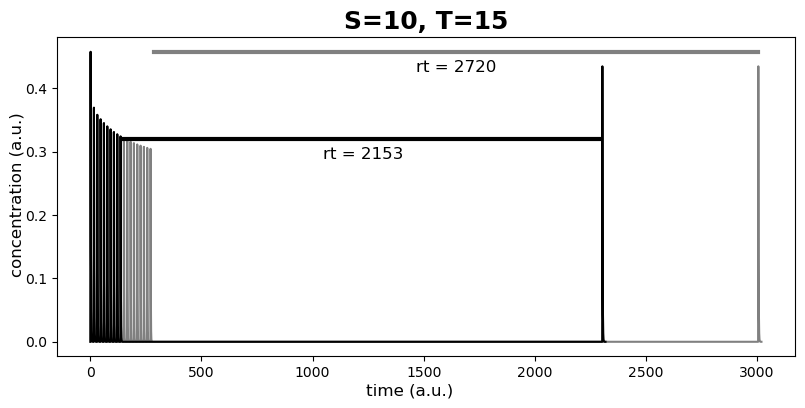

In [15]:
### plot
# concatenate data for plot
x_high_threshold = np.concatenate([data_high["trajectory"][:,mys.output_variable][:htstp1], 
                     recovery_trajectory_high_threshold[:int(rt_high_threshold*mys.steps_per_time),mys.output_variable],
                     recovery_peak_high_threshold[:,mys.output_variable]])
x_low_threshold = np.concatenate([data_low["trajectory"][:,mys.output_variable][:htstp2], 
                     recovery_trajectory_high_threshold[:int(rt_low_threshold*mys.steps_per_time),mys.output_variable],
                     recovery_peak_low_threshold[:,mys.output_variable]])
t_high_threshold = np.arange(0,len(x_high_threshold))/mys.steps_per_time
t_low_threshold = np.arange(0,len(x_low_threshold))/mys.steps_per_time
max_peak = max(data["peaks_level"])


fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 4))
ax = axes
ax.plot(t_low_threshold, x_low_threshold, color='grey')
ax.plot([ht_low_threshold*T, ht_low_threshold*T+rt_low_threshold], [max_peak, max_peak], 
        color='grey', lw=3)
ax.text(ht_low_threshold*T+0.5*rt_low_threshold, 0.93*max_peak, 
        'rt = '+str(round(rt_low_threshold)), ha='center', fontsize=12)

ax.plot(t_high_threshold, x_high_threshold, color='black')
ax.plot([ht_high_threshold*T-5, ht_high_threshold*T+rt_high_threshold-15], [0.7*max_peak, 0.7*max_peak], 
        color='black', lw=3) # -5 arbiträr!!!
ax.text(ht_high_threshold*T+0.5*rt_high_threshold, 0.63*max_peak, 
        'rt = '+str(round(rt_high_threshold)), ha='center', fontsize=12)

fig.text(0.5, -0, 'time (a.u.)', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'concentration (a.u.)', va='center', rotation='vertical', fontsize=12)
plt.title("S=" + str(S) + ", T=" + str(T),  fontweight="bold", fontsize=18)
#sns.despine()
plt.tight_layout()
#plt.savefig(DATA+'22_06_22_7/figures/thesis_0/subliminal_overlay.pdf')
plt.show()